## Goal
As a first pass at developing a machine learning model to predict California wildfires I will evaluate and tune several different gradient boosting algorithms. The procedure will be as follows:

1. Determine the best gradient boosting for the data
2. Determine the best scoring function/metric for optimization
3. Tune model hyperparameters
4. Investigate feature importance and possibly trim/apply dimensionality reduction techniques to the data

There are two anticipated issues which will need to be dealt with first:

1. Large dataset size - current working dataset has 7.3 million observations of 25 variables and this is likely to grow as the project progresses
2. Highly imbalanced data (~20 times more observations without fire than with)

Future goals are to add several more factors from various data sources including: elevation, population density, time since last fire and total fires.

**Imports and notebook setup**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

from time import time
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from IPython.display import display_markdown
from scipy.interpolate import griddata

%matplotlib inline
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

**Variable definitions**

In [2]:
data_file = '../data/training_data/1992-1997_training_data.csv'
rand_seed = 123
data_sample_size = 10000
test_train_split_ratio = 0.3
xgb_jobs = 5
optimization_jobs = 3
search_iterations = 100
search_scoring_func = make_scorer(average_precision_score)

**Functions**

In [15]:
def k_random_sample(data, k):
    n = len(data)
    
    indices = random.sample(range(0, n), k)
    
    return data.iloc[indices]

def stratified_train_test_split(data, targets, rand_seed):
    sss = StratifiedShuffleSplit(
        n_splits=1,
        test_size=test_train_split_ratio, 
        random_state=rand_seed
    )

    for train_index, test_index in sss.split(data, targets):
        x_train, x_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = targets.iloc[train_index], targets.iloc[test_index]
        
        return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

def calc_false_neg_pos_rate(model, x_test, y_test):
    cm = confusion_matrix(y_test, model.predict(x_test))

    TN = cm[0][0]
    FN = cm[1][0]
    FP = cm[0][1]

    false_neg_rate = FN / (FN + TN)
    false_pos_rate = FP / (FP + TN)
    
    return false_neg_rate, false_pos_rate

def compare_algorithms(
    classifiers, 
    model_descriptions,  
    x_train, 
    y_train, 
    x_test, 
    y_test
):
    model_scores_columns = ['Model description', 'Training score', 'Test score', 'False positive rate', 'False negative rate']
    model_scores = pd.DataFrame(columns=model_scores_columns)
    
    for classifier, description in zip(classifiers, model_descriptions):
        model = classifier
        model.fit(x_train, y_train)

        training_score = average_precision_score(model.predict(x_train), y_train)
        test_score = average_precision_score(model.predict(x_test), y_test)
        false_neg_rate, false_pos_rate = calc_false_neg_pos_rate(model, x_test, y_test)
        model_scores = model_scores.append(pd.Series([description, np.round(training_score,2), np.round(test_score,2), np.round(false_pos_rate,2), np.round(false_neg_rate,2)], index=model_scores.columns), ignore_index=True)

        normalized_cm = plot_confusion_matrix(
            model, 
            x_test, 
            y_test,
            display_labels=class_names,                         
            cmap=plt.cm.Blues,
            normalize='true'
        )

        normalized_cm.ax_.set_title("Normalized confusion matrix\n {}".format(description))

        plt.show()
        
    return model_scores
    
def test_scoring_functions(
    scoring_functions, 
    x_train, 
    y_train, 
    x_test, 
    y_test
):
    model_scores_columns = ['Scoring function','Training score','Test score','False positive rate','False negative rate']
    model_scores = pd.DataFrame(columns=model_scores_columns)

    for scoring_function in scoring_functions:
        catboost_mod = CatBoostClassifier(
            thread_count = (xgb_jobs * optimization_jobs),
            score_function = scoring_function
        )

        catboost_mod.fit(x_train, y_train, silent=True)

        training_score = average_precision_score(catboost_mod.predict(x_train), y_train)
        test_score = average_precision_score(catboost_mod.predict(x_test), y_test)
        false_neg_rate, false_pos_rate = calc_false_neg_pos_rate(catboost_mod, x_test, y_test)
        model_scores = model_scores.append(pd.Series([scoring_function, np.round(training_score,2), np.round(test_score,2), np.round(false_pos_rate,2), np.round(false_neg_rate,2)], index=model_scores.columns), ignore_index=True)

    return model_scores

def tune_hyperparameters(
    known_params,
    param_dist, 
    x_train, 
    y_train, 
    num_jobs, 
    search_iterations, 
    search_scoring_func
):

    # initalize XGBoost classifier
    xgb_mod = XGBClassifier(**known_params)

    # set up random search
    xgb_random_search = RandomizedSearchCV(
        xgb_mod, 
        param_distributions=param_dist,
        scoring=search_scoring_func,
        n_iter=search_iterations,
        n_jobs=num_jobs
    )

    # run and time search
    start = time()
    xgb_best_model = xgb_random_search.fit(x_train, y_train)
    print("RandomizedSearchCV took %.f min. for %d candidate"
          " parameter settings." % (((time() - start)/60), search_iterations))
    
    return xgb_best_model, xgb_random_search

def regularize_grid(x, y, z, resolution):

    # target grid to interpolate to
    xi = np.arange(min(x), max(x), ((max(x) - min(x)) / resolution))
    yi = np.arange(min(y), max(y), ((max(y) - min(y)) / resolution))
    xi, yi = np.meshgrid(xi, yi)

    # interpolate
    zi = griddata((x, y), z, (xi, yi), method='linear')
    
    return xi, yi, zi

## Data preparation

In [4]:
# read data
data = pd.read_csv(data_file, low_memory=False)

# set ignition to 0 for noxels with no fire
data['ignition'].fillna(0, inplace=True)

# count number of observations in each class
ignition_count = len(data[data["ignition"] == 1])
no_ignition_count = len(data) - ignition_count
print('Total observations: {:.1E}'.format(len(data)))
print('Ignitions count: {:.1E}'.format(ignition_count))
print('Non ignitions count: {:.1E}'.format(no_ignition_count))

Total observations: 7.3E+06
Ignitions count: 3.7E+05
Non ignitions count: 6.9E+06


OK, so before we dig into this much farther, I am noticing an issue. For some fires we know the discovery time and some we do not. I can imagine a few ways of dealing with this:

1. Throw out fires for which we do not know the discovery time
2. Average everything at the day resolution level

I am leaning toward option two because:

1. Discovery time is not ignition time so the weather state during that exact hour may not be pertinent anyway - for example: what if the fire had already been burning for hours and the temperature had changed drastically?
2. The data is already skewed toward no ignition observations. I would rather not have to throw out even more fires. Also, doing so will mean that I have noxels where there was a fire which was not included in the dataset. 

Specific plan is to roll a daily moving average across the data, including ignition value. This will assign an ignition value to all noxels within 24 hr. of a fire's discovery day.

In [5]:
# roll data with 24 hr windowed mean
data_moving_avg = data.groupby(['lat', 'lon']).rolling(24, on="weather_bin_time").mean()
data_moving_avg.reset_index(drop=True, inplace=True)

# clean up dataframe
data_moving_avg['weather_bin_time'] = pd.to_datetime(data_moving_avg['weather_bin_time'])
data_moving_avg['weather_bin_month'] = data_moving_avg['weather_bin_time'].dt.month
data_moving_avg['weather_bin_year'] = data_moving_avg['weather_bin_time'].dt.year
data_moving_avg.drop(['fire_discovery_time', 'size', 'size_class', 'weather_bin_time'], axis=1, inplace=True)
data_moving_avg.dropna(inplace=True)

# split positive and negative datsets up
ignitions = data_moving_avg[data_moving_avg['ignition'] > 0]
no_ignitions = data_moving_avg[data_moving_avg['ignition'] == 0]

# due to the moving average we will have some positive observations with
# fractional ignition values
ignitions = ignitions.assign(ignition=1)

OK, now we need to pseudorandomly sample the positive and negative datasets. This will accomplish two goals:
    
1. Make the dataset size smaller
2. Equalize the number of positive and negative observations

In [6]:
no_ignitions_sample = k_random_sample(no_ignitions, data_sample_size)
ignitions_sample = k_random_sample(ignitions, data_sample_size)

sampled_data = no_ignitions_sample.append(ignitions_sample)
class_names = np.array(['No ignition', 'Ignition'])

print('Total observations: {:.1E}'.format(len(sampled_data)))
print('Ignitions count: {:.1E}'.format(len(ignitions_sample)))
print('Non ignitions count: {:.1E}'.format(len(no_ignitions_sample)))

Total observations: 2.0E+04
Ignitions count: 1.0E+04
Non ignitions count: 1.0E+04


In [7]:
targets = sampled_data['ignition']
data = sampled_data.drop(['ignition'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(data.values, targets.values, random_state=rand_seed)

**Game on!** Let's keep track of our results as we begin to play with the data:

## Default model: XGBoost vs CATBoost vs LightGBM vs random forest

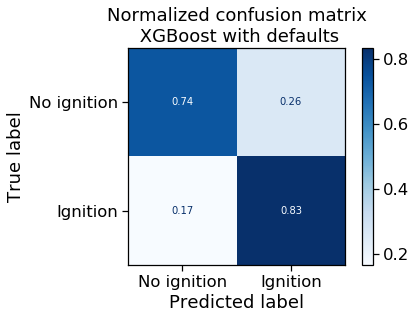

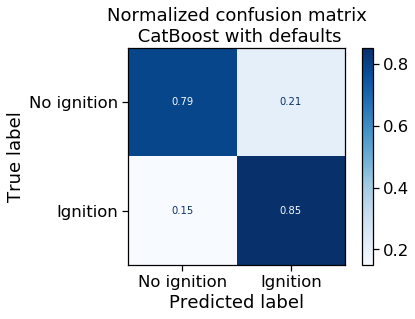

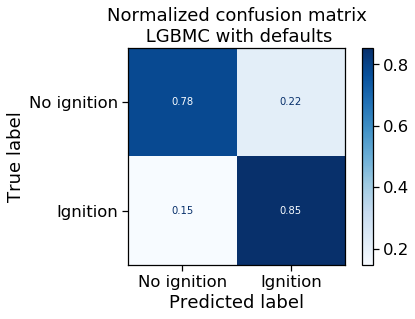

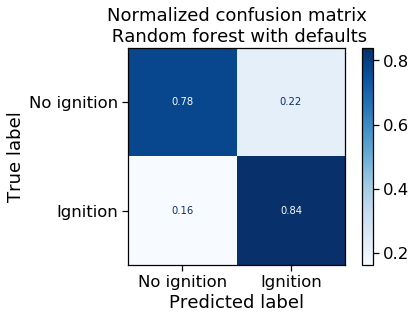

,Model description,Training score,Test score,False positive rate,False negative rate
0,XGBoost with defaults,0.77,0.77,0.26,0.19
1,CatBoost with defaults,0.88,0.79,0.21,0.16
2,LGBMC with defaults,0.85,0.79,0.22,0.16
3,Random forest with defaults,1.00,0.78,0.22,0.18


In [8]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

model_descriptions = [
    'XGBoost with defaults',
    'CatBoost with defaults',
    'LightGBM. with defaults',
    'Random forest with defaults'
]

threads = (xgb_jobs * optimization_jobs)

classifiers = (
    XGBClassifier(n_jobs = threads), 
    CatBoostClassifier(thread_count = threads, silent = True), 
    LGBMClassifier(n_jobs = threads), 
    RandomForestClassifier(n_jobs = threads)
)

model_scores = compare_algorithms(
    classifiers, 
    model_descriptions, 
    x_train, 
    y_train, 
    x_test, 
    y_test
 )
    
model_scores

Judging from false negative and false positive rates CatBoost is our winner. Because of the nature of the data, it is extremely important to minimize the false negative rate. False positives might be economically wasteful, but false negatives have the potential to cause injury and loss of life. Provisionally, let's continue on with CatBoost.

## Scoring function selection

In [16]:
# note: catboost only has cosine and L2 avalible for non GPU computation
scoring_functions = [
#    'SolarL2',
     'Cosine', 
#     'NewtonL2', 
#     'NewtonCosine', 
#     'LOOL2', 
#     'SatL2', 
     'L2'
]

model_scores = test_scoring_functions(
    scoring_functions, 
    x_train, 
    y_train, 
    x_test, 
    y_test
)

model_scores

,Scoring function,Training score,Test score,False positive rate,False negative rate
0,Cosine,0.88,0.79,0.21,0.16
1,L2,0.88,0.79,0.21,0.17


Ok, looks similar, the cosine false negative rate is slightly lower, so let's go with that. 